# 🌟 Polarization Image Processing

## 🌐 Language Selection

Please run the next cell to select your preferred language interface.

---

**English**: This notebook provides an interactive interface for analyzing polarization data from astronomical FITS files.

c:\Users\ADMIN\miniconda3\envs\astro_env\lib\site-packages\skimage\registration\_phase_cross_correlation.py:119: RuntimeWarning: overflow encountered in scalar multiply
  amp = src_amp * target_amp


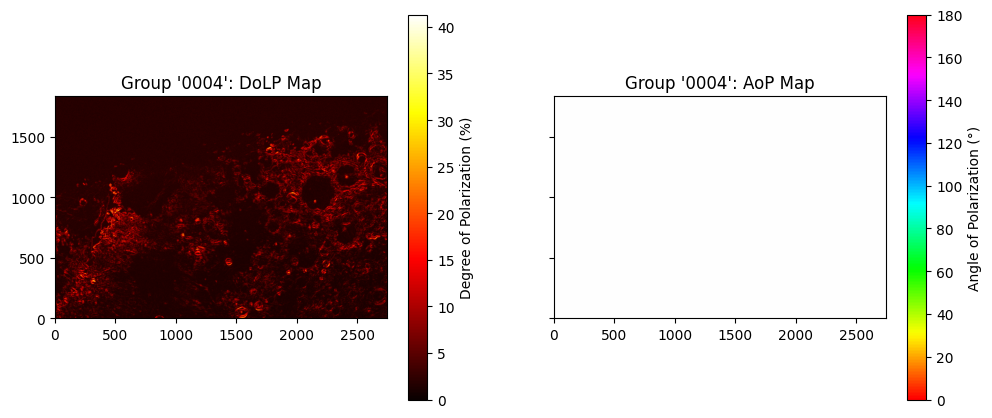

In [2]:
import tkinter as tk
from tkinter import filedialog, messagebox, Toplevel, Label, Button, Scale, HORIZONTAL, Text, END, INSERT, DoubleVar, OptionMenu
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
from matplotlib import cm
# %pip install scikit-image # This line is for environment setup, not part of the runnable code
from skimage import img_as_float # Imported but not explicitly used in the final version, as astype(float) is sufficient
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift, zoom, gaussian_filter # zoom added for downsampling in 3D plot, gaussian_filter for smoothing
from joblib import Parallel, delayed
import os
import csv
import queue
import threading
import re
from mpl_toolkits.mplot3d import Axes3D # Import for 3D plotting
# Import for WCS alignment (if implemented fully)
from astropy.wcs import WCS
from reproject import reproject_interp # You would need to install reproject: pip install reproject
from skimage.filters import median # NEW: Import for denoising

# --- Helper functions for Joblib (run in child processes) ---

def _load_and_extract_info_single_file(filepath):
    """
    Loads a FITS image and attempts to extract angle and sequence ID from the filename
    and/or FITS header.
    Returns (sequence_id, angle, image_data, header) if successful, otherwise (None, None, None, None).
    """
    try:
        with fits.open(filepath) as hdul:
            header = hdul[0].header
            image_data = hdul[0].data.astype(float) # Ensure data is float for calculations
            
            filename = os.path.basename(filepath)
            
            # Regex to find sequence ID and angle from filename (e.g., -YYYY-ANGLE.fits)
            match = re.search(r'-(\d{4})-(\d{1,3})\.fits$', filename, re.IGNORECASE)
            if not match:
                match = re.search(r'-(\d{4})-(\d{1,3})\.fit$', filename, re.IGNORECASE)

            file_angle = None
            sequence_id = None

            if match:
                sequence_id = match.group(1)
                file_angle = match.group(2)

            # Try to get angle from FITS header 'FILTER' keyword
            filter_value = header.get('FILTER', '').strip().upper()

            angle_mapping = {
                "POL0": "0", "POLARIZER0": "0", "0DEG": "0", "0": "0",
                "POL45": "45", "POLARIZER45": "45", "45DEG": "45", "45": "45",
                "POL90": "90", "POLARIZER90": "90", "90DEG": "90", "90": "90",
                "POL135": "135", "POLARIZER135": "135", "135DEG": "135", "135": "135",
            }
            header_angle = angle_mapping.get(filter_value)

            # Prioritize header angle if available and valid, otherwise use file angle
            final_angle = header_angle if header_angle else file_angle

            if final_angle and sequence_id:
                # Validate angle to be one of the expected polarization angles
                if final_angle in ["0", "45", "90", "135"]:
                    return sequence_id, final_angle, image_data, header # Return header as well
                else:
                    return None, None, None, None # Invalid angle found
            else:
                return None, None, None, None # Missing sequence ID or angle
    except Exception as e:
        # print(f"Error loading file {filepath}: {e}") # For debugging, can be commented out
        return None, None, None, None # Return None on any error during loading/extraction

def _header_based_pre_alignment(image_data, image_header, reference_header, reference_image_shape):
    """
    Performs initial alignment based on FITS header information (e.g., rotation, scaling)
    using WCS reprojection with 'reproject' library.
    
    Parameters:
    - image_data: numpy array, the image data to align.
    - image_header: astropy.io.fits.Header, header of the image_data.
    - reference_header: astropy.io.fits.Header, header of the reference image (e.g., 0-degree image).
    - reference_image_shape: tuple, the (height, width) shape of the reference image.
    
    Returns:
    - aligned_image_data: numpy array, the pre-aligned image data.
    """
    aligned_image_data = image_data.copy()

    try:
        wcs_img = WCS(image_header)
        wcs_ref = WCS(reference_header)
        
        # Check if WCS objects are valid and have pixel information
        # A minimal check for valid WCS is if `wcs.naxis` is greater than 0
        if wcs_img.naxis == 0 or wcs_ref.naxis == 0:
            raise ValueError("WCS information is incomplete or invalid for reprojection.")

        # Reproject the image data onto the reference WCS grid
        # The shape_out should be the shape of the target image (reference image)
        aligned_image_data, _ = reproject_interp((image_data, wcs_img), wcs_ref, 
                                                shape_out=reference_image_shape, 
                                                order='bilinear')
        
        # Ensure the reprojected image has the same data type as the original for consistency
        aligned_image_data = aligned_image_data.astype(image_data.dtype)

    except ImportError:
        # This block should ideally not be hit if imports are at the top and checked once.
        # But keeping it for robustness if reproject is conditionally imported or fails later.
        # In a real app, this warning should go to the user via the GUI log.
        pass # Fallback to no WCS alignment if reproject is missing
    except Exception as e:
        # Handle other potential errors during WCS reprojection (e.g., invalid WCS, memory issues)
        # This warning should also go to the user via the GUI log.
        pass # Fallback to no WCS alignment if WCS info is missing or invalid

    return aligned_image_data

def _align_by_brightest_point(moving_image, reference_image, enable_gaussian_smoothing, gaussian_sigma): # NEW: Added parameters
    """
    Aligns moving_image to reference_image based on their brightest pixel locations.
    Optionally applies Gaussian smoothing to make brightest point detection more robust to noise
    and representative of a brighter region.
    """
    try:
        # Clean images from NaN/inf values before finding brightest point
        moving_image_clean = np.nan_to_num(moving_image, nan=0.0, posinf=0.0, neginf=0.0)
        reference_image_clean = np.nan_to_num(reference_image, nan=0.0, posinf=0.0, neginf=0.0)

        # NEW: Apply Gaussian smoothing if enabled
        if enable_gaussian_smoothing and gaussian_sigma > 0:
            moving_image_clean = gaussian_filter(moving_image_clean, sigma=gaussian_sigma)
            reference_image_clean = gaussian_filter(reference_image_clean, sigma=gaussian_sigma)

        # Find the coordinates of the brightest pixel in each image
        ref_brightest_coords = np.unravel_index(np.argmax(reference_image_clean), reference_image_clean.shape)
        mov_brightest_coords = np.unravel_index(np.argmax(moving_image_clean), moving_image_clean.shape)

        # Calculate the shift required (reference_coords - moving_coords)
        shift_yx = np.array(ref_brightest_coords) - np.array(mov_brightest_coords)

        # Apply the shift to the original (potentially non-cleaned) image
        aligned_image = shift(moving_image, shift=shift_yx, mode='nearest')
        return aligned_image
    except Exception as e:
        raise Exception(f"Error aligning by brightest point: {e}")


def _align_single_image(moving_image, reference_image, enable_denoising): 
    """
    Helper function to align a single image using phase_cross_correlation.
    Optionally applies median denoising before correlation.
    """
    try:
        # Check if images are too small for phase_cross_correlation
        if min(moving_image.shape) < 2 or min(reference_image.shape) < 2:
            raise ValueError("Image dimensions too small for phase_cross_correlation. Minimum 2x2 required.")

        # Handle NaN/inf values in images by replacing them with 0.0
        moving_image_clean = np.nan_to_num(moving_image, nan=0.0, posinf=0.0, neginf=0.0)
        reference_image_clean = np.nan_to_num(reference_image, nan=0.0, posinf=0.0, neginf=0.0)

        # Apply median denoising if enabled
        if enable_denoising:
            # Median filter works well on integer types or float.
            # Convert to float for median, then back to original type if needed, but here we want float for correlation.
            moving_image_clean = median(moving_image_clean.astype(np.float32), behavior='ndimage')
            reference_image_clean = median(reference_image_clean.astype(np.float32), behavior='ndimage')

        # Perform phase cross-correlation to find the shift
        shift_yx, error, diffphase = phase_cross_correlation(
            reference_image_clean, moving_image_clean, upsample_factor=10
        )
        # Apply the calculated shift to the moving image
        aligned_image = shift(moving_image, shift=shift_yx, mode='nearest')
        return aligned_image
    except Exception as e:
        # print(f"Error aligning single image: {e}") # For debugging
        raise Exception(f"Error aligning single image: {e}") # Re-raise to be caught at a higher level

def _perform_all_alignments_for_single_group(group_images_raw_with_headers, use_celestial_alignment, enable_denoising, enable_gaussian_smoothing, gaussian_sigma): # NEW: Added gaussian params
    """
    Performs all alignment steps (header-based, brightest point, phase cross-correlation)
    for a single group of images.
    Returns a dictionary of aligned image data {angle: aligned_image_data}.
    """
    required_angles = ["0", "45", "90", "135"]
    group_data = {a: group_images_raw_with_headers[a]['data'] for a in required_angles}
    group_headers = {a: group_images_raw_with_headers[a]['header'] for a in required_angles}

    aligned_group_data = {}
    reference_image_data = group_data["0"]
    reference_image_header = group_headers["0"]
    reference_image_shape = reference_image_data.shape # Get shape of reference image

    aligned_group_data["0"] = reference_image_data.copy()

    angles_to_align = ["45", "90", "135"]
    for angle in angles_to_align:
        moving_image_data = group_data[angle]
        moving_image_header = group_headers[angle]

        # Pass reference_image_shape to _header_based_pre_alignment
        pre_aligned_image = _header_based_pre_alignment(moving_image_data, moving_image_header, reference_image_header, reference_image_shape)

        if use_celestial_alignment:
            # NEW: Pass gaussian parameters to _align_by_brightest_point
            pre_aligned_image = _align_by_brightest_point(pre_aligned_image, reference_image_data, enable_gaussian_smoothing, gaussian_sigma)

        # Pass enable_denoising to _align_single_image
        aligned_group_data[angle] = _align_single_image(pre_aligned_image, reference_image_data, enable_denoising)
    return aligned_group_data


def _calculate_polarization_maps_for_group(sequence_id, group_images_raw_with_headers, stokes_formulas, p_formula_str, theta_formula_str, use_celestial_alignment, enable_denoising, enable_gaussian_smoothing, gaussian_sigma): # NEW: Added gaussian params
    """
    Processes a complete group of images: performs all alignments,
    calculates Stokes parameters, and then DoLP (P) and AoP (Theta).
    This function is designed to be parallelized by Joblib.
    Returns (sequence_id, dolp_map, aop_map) if successful, otherwise None.
    """
    try:
        # Perform all alignments first, passing enable_denoising and gaussian parameters
        aligned_images = _perform_all_alignments_for_single_group(group_images_raw_with_headers, use_celestial_alignment, enable_denoising, enable_gaussian_smoothing, gaussian_sigma)

        # Assign aligned images to variables for formula evaluation
        I_0 = np.nan_to_num(aligned_images["0"].copy(), nan=0.0, posinf=0.0, neginf=0.0) # Ensure no NaNs/Infs
        I_45 = np.nan_to_num(aligned_images["45"].copy(), nan=0.0, posinf=0.0, neginf=0.0) # Ensure no NaNs/Infs
        I_90 = np.nan_to_num(aligned_images["90"].copy(), nan=0.0, posinf=0.0, neginf=0.0) # Ensure no NaNs/Infs
        I_135 = np.nan_to_num(aligned_images["135"].copy(), nan=0.0, posinf=0.0, neginf=0.0) # Ensure no NaNs/Infs

        # Calculate Stokes parameters using user-defined formulas
        local_vars_stokes = {
            "I_0": I_0, "I_45": I_45, "I_90": I_90, "I_135": I_135, "np": np
        }
        # Use eval with restricted builtins for safety
        S0 = eval(stokes_formulas["S0"], {"__builtins__": None}, local_vars_stokes)
        S1 = eval(stokes_formulas["S1"], {"__builtins__": None}, local_vars_stokes)
        S2 = eval(stokes_formulas["S2"], {"__builtins__": None}, local_vars_stokes)

        # Calculate P (DoLP) and Theta (AoP)
        epsilon = 1e-6 # Small value to prevent division by zero for S0
        S0_safe = np.where(S0 < epsilon, epsilon, S0) # Replace very small S0 with epsilon

        polarization_local_vars = {
            "S0": S0, "S1": S1, "S2": S2, "S0_safe": S0_safe, "np": np
        }
        
        # Evaluate P and Theta formulas
        DOLP_map = eval(p_formula_str, {"__builtins__": None}, polarization_local_vars)
        AOP_map = eval(theta_formula_str, {"__builtins__": None}, polarization_local_vars)
        
        # Ensure AoP is within 0-180 degrees (common convention for polarization angle)
        AOP_map = np.where(AOP_map < 0, AOP_map + 180, AOP_map)
        AOP_map = np.nan_to_num(AOP_map, nan=0.0, posinf=0.0, neginf=0.0) # Ensure AoP map is clean
        DOLP_map = np.nan_to_num(DOLP_map, nan=0.0, posinf=0.0, neginf=0.0) # Ensure DoLP map is clean


        return sequence_id, DOLP_map, AOP_map

    except Exception as e:
        # print(f"Error processing group '{sequence_id}': {e}") # For debugging
        return None # Return None if there's an error in this group's processing


# --- End Helper Functions ---


class PolarizationCalculatorApp:
    def __init__(self, master):
        self.master = master
        master.title("Polarization Image Calculator")

        self.image_dir = tk.StringVar()
        # Stores raw loaded images, grouped by sequence_id and angle
        # Now stores {'data': raw_image_data, 'header': fits_header}
        self.raw_grouped_images = {} # {sequence_id: {'0': {'data': ..., 'header': ...}, '45': {...}, ...}}

        self.DOLP_map_results = {} # Stores {sequence_id: DoLP_map}
        self.AOP_map_results = {} # Stores {sequence_id: AoP_map}
        
        self.result_windows = [] # List to keep track of all open result windows (including the main one)
        self.active_3d_axes = [] # List to store references to active 3D axes for synchronization
        self._sync_lock = threading.Lock() # Lock to prevent re-entrant calls during synchronization

        # Default Stokes formulas
        self.stokes_formulas = {
            "S0": "0.5 * (I_0 + I_90 + I_45 + I_135)",
            "S1": "I_0 - I_90",
            "S2": "I_45 - I_135"
        }
        
        # Default P and Theta formulas (P in percentage, Theta in degrees)
        self.p_formula = tk.StringVar(value="np.sqrt(S1**2 + S2**2) / S0_safe * 100") 
        self.theta_formula = tk.StringVar(value="0.5 * np.degrees(np.arctan2(S2, S1))")

        self.downsample_factor_3d = DoubleVar(value=0.25) # Variable for 3D downsampling factor
        self.use_celestial_alignment = tk.BooleanVar(value=False) # Checkbox for brightest point alignment
        self.manual_alignment_enabled = tk.BooleanVar(value=False) # Checkbox for manual alignment
        self.enable_denoising_alignment = tk.BooleanVar(value=True) # Checkbox for denoising before alignment

        # NEW: Gaussian smoothing for brightest point alignment
        self.enable_gaussian_smoothing = tk.BooleanVar(value=True)
        self.gaussian_sigma = tk.DoubleVar(value=2.0) # Default sigma value for Gaussian filter

        self.message_queue = queue.Queue() # Queue for thread-safe logging
        self.log_window = None
        self.log_text = None

        # New instance variables for manual alignment state
        self._manual_align_window = None
        self._manual_align_canvas = None
        self._manual_align_ax = None
        self._manual_align_image_display = None
        self._manual_align_current_angle_idx = 0 # 0 for 0deg, 1 for 45deg, etc.
        self._manual_align_angles = ["0", "45", "90", "135"]
        self._manual_align_points_clicked = {} # {angle: (y, x)} for shift calculation
        self._manual_align_current_image_data = None
        self._manual_align_current_group_id = None
        self._manual_align_instruction_label = None
        self._manual_align_apply_button = None
        self._manual_align_colorbar = None # To store colorbar object

        # Variables for manual alignment histogram sliders
        self.vmin_manual_align = tk.DoubleVar()
        self.vmax_manual_align = tk.DoubleVar()


        self.aligned_input_images_for_first_group = {} # Stores {angle: aligned_image_data} for first group

        # Variables for main result display window
        self.main_result_window = None
        self.current_display_group_idx = 0 # Index into sorted list of sequence_ids
        self.displayed_sequence_ids = [] # List of sequence_ids that have results
        self.main_result_canvas = None
        self.main_result_ax_dolp = None
        self.main_result_ax_aop = None
        self.main_result_dolp_image = None
        self.main_result_aop_image = None
        self.main_result_polarization_value_label = None
        self.main_result_vmin_val = tk.DoubleVar()
        self.main_result_vmax_val = tk.DoubleVar()
        self.main_result_arrow_downsample_var = tk.DoubleVar(value=8.0) # For AoP arrows
        self.group_selection_var = tk.StringVar() # For dropdown/entry to select group
        self.group_selection_menu = None # To store the OptionMenu widget


        self.create_widgets()
        self.create_log_window()
        self.process_queue() # Start checking the message queue for updates

    def create_widgets(self):
        # Frame for directory path selection
        dir_frame = tk.LabelFrame(self.master, text="Select Folder Containing All Polarization Images (FITS)")
        dir_frame.pack(padx=10, pady=10, fill="x")

        row = tk.Frame(dir_frame)
        row.pack(fill="x", padx=5, pady=2)

        label = tk.Label(row, text="Image folder:")
        label.pack(side=tk.LEFT, padx=5)

        entry = tk.Entry(row, textvariable=self.image_dir, width=60)
        entry.pack(side=tk.LEFT, expand=True, fill="x", padx=5)

        button = tk.Button(row, text="Browse Folder...", command=self.load_image_directory)
        button.pack(side=tk.RIGHT)

        # Frame for Stokes formula configuration
        formula_stokes_frame = tk.LabelFrame(self.master, text="Configure Stokes Formulas (Using I_0, I_45, I_90, I_135)")
        formula_stokes_frame.pack(padx=10, pady=10, fill="x")

        self.stokes_formula_widgets = {} # To hold Text widgets for Stokes formulas
        for stokes_param in ["S0", "S1", "S2"]:
            row = tk.Frame(formula_stokes_frame)
            row.pack(fill="x", padx=5, pady=2)
            tk.Label(row, text=f"{stokes_param}:").pack(side=tk.LEFT, padx=5)
            text_widget = Text(row, height=1, width=50)
            text_widget.insert(INSERT, self.stokes_formulas[stokes_param])
            text_widget.pack(side=tk.LEFT, expand=True, fill="x")
            self.stokes_formula_widgets[stokes_param] = text_widget
        
        # Frame for P and Theta formula configuration
        formula_polarization_frame = tk.LabelFrame(self.master, text="Configure P (DoLP) and Theta (AoP) Calculation Formulas (Using S0, S1, S2, S0_safe, np)")
        formula_polarization_frame.pack(padx=10, pady=10, fill="x")

        # P formula entry
        row_p = tk.Frame(formula_polarization_frame)
        row_p.pack(fill="x", padx=5, pady=2)
        tk.Label(row_p, text="P formula (%):").pack(side=tk.LEFT, padx=5)
        self.p_formula_entry = tk.Entry(row_p, textvariable=self.p_formula, width=50)
        self.p_formula_entry.pack(side=tk.LEFT, expand=True, fill="x")

        # Theta formula entry
        row_theta = tk.Frame(formula_polarization_frame)
        row_theta.pack(fill="x", padx=5, pady=2)
        tk.Label(row_theta, text="Theta formula (degrees):").pack(side=tk.LEFT, padx=5)
        self.theta_formula_entry = tk.Entry(row_theta, textvariable=self.theta_formula, width=50)
        self.theta_formula_entry.pack(side=tk.LEFT, expand=True, fill="x")

        # Button to save formulas
        save_formula_button = tk.Button(formula_polarization_frame, text="Save Formulas", command=self.save_formulas)
        save_formula_button.pack(pady=5)

        # Frame for 3D plot settings
        plot3d_settings_frame = tk.LabelFrame(self.master, text="3D Plot Settings")
        plot3d_settings_frame.pack(padx=10, pady=10, fill="x")

        row_downsample = tk.Frame(plot3d_settings_frame)
        row_downsample.pack(fill="x", padx=5, pady=2)
        tk.Label(row_downsample, text="3D Downsample Factor (0.01 - 1.0):").pack(side=tk.LEFT, padx=5)
        scale_downsample = Scale(row_downsample, from_=0.01, to_=1.0, resolution=0.01, orient=HORIZONTAL,
                                 variable=self.downsample_factor_3d, length=200)
        scale_downsample.pack(side=tk.LEFT, expand=True, fill="x")
        tk.Label(row_downsample, textvariable=self.downsample_factor_3d, width=5).pack(side=tk.LEFT)

        # Alignment options frame
        alignment_options_frame = tk.LabelFrame(self.master, text="Image Alignment Options")
        alignment_options_frame.pack(padx=10, pady=10, fill="x")
        tk.Checkbutton(alignment_options_frame, text="Pre-align by Brightest Point (Celestial)", variable=self.use_celestial_alignment).pack(anchor="w", padx=5, pady=2)
        tk.Checkbutton(alignment_options_frame, text="Enable Manual Alignment (First Group Only)", variable=self.manual_alignment_enabled).pack(anchor="w", padx=5, pady=2)
        # Denoising option
        tk.Checkbutton(alignment_options_frame, text="Enable Denoising (Median Filter) Before Alignment", variable=self.enable_denoising_alignment).pack(anchor="w", padx=5, pady=2)
        
        # NEW: Gaussian smoothing for brightest point alignment
        tk.Checkbutton(alignment_options_frame, text="Enable Gaussian Smoothing for Brightest Point Alignment", variable=self.enable_gaussian_smoothing).pack(anchor="w", padx=5, pady=2)
        row_gaussian_sigma = tk.Frame(alignment_options_frame)
        row_gaussian_sigma.pack(fill="x", padx=5, pady=2)
        tk.Label(row_gaussian_sigma, text="Gaussian Width (σ):").pack(side=tk.LEFT, padx=5)
        scale_gaussian_sigma = Scale(row_gaussian_sigma, from_=0.1, to_=10.0, resolution=0.1, orient=HORIZONTAL,
                                 variable=self.gaussian_sigma, length=200)
        scale_gaussian_sigma.pack(side=tk.LEFT, expand=True, fill="x")
        tk.Label(row_gaussian_sigma, textvariable=self.gaussian_sigma, width=5).pack(side=tk.LEFT)

        # Button to trigger manual alignment process (which will be blocking)
        manual_align_button = tk.Button(alignment_options_frame, text="Perform Manual Alignment", command=self._start_manual_alignment_process_ui)
        manual_align_button.pack(pady=5)


        # Frame for action buttons
        action_buttons_frame = tk.Frame(self.master)
        action_buttons_frame.pack(pady=10)

        # Calculate button
        calculate_button = tk.Button(action_buttons_frame, text="Calculate Polarization (By Group)", command=self.start_calculation_thread)
        calculate_button.pack(side=tk.LEFT, padx=5)

        # Clear all button
        clear_button = tk.Button(action_buttons_frame, text="Clear All", command=self.clear_all_data_and_windows)
        clear_button.pack(side=tk.LEFT, padx=5)

        # Placeholder for results display - Actual results will be in new windows
        tk.Label(self.master, text="Results will be displayed in a main window after calculation.").pack(pady=10)

        # Button to create 3D plot (updated)
        plot3d_button = tk.Button(self.master, text="Create 3D Polarization Plot", command=self.show_3d_polarization_plots)
        plot3d_button.pack(pady=10)

        # NEW: Button to show aligned input images
        show_aligned_images_button = tk.Button(self.master, text="Show Aligned Input Images (First Group)", command=self._show_aligned_input_images)
        show_aligned_images_button.pack(pady=10)

        # NEW: Button to open interactive alignment check window
        check_alignment_button = tk.Button(self.master, text="Check Alignment (Overlay)", command=self._open_alignment_check_window)
        check_alignment_button.pack(pady=10)


    def save_formulas(self):
        """Saves the formulas entered by the user."""
        try:
            for stokes_param, widget in self.stokes_formula_widgets.items():
                self.stokes_formulas[stokes_param] = widget.get("1.0", END).strip()
            
            self.p_formula.set(self.p_formula_entry.get().strip())
            self.theta_formula.set(self.theta_formula_entry.get().strip())

            messagebox.showinfo("Information", "Formulas saved successfully!")
            self.log_message("Stokes, P, and Theta calculation formulas have been updated.")
        except Exception as e:
            messagebox.showerror("Error", f"Unable to save formulas: {e}")
            self.log_message(f"Error saving formulas: {e}")

    def create_log_window(self):
        """Creates a separate window for logging messages."""
        self.log_window = Toplevel(self.master)
        self.log_window.title("Processing Log")
        self.log_window.geometry("500x300")
        # Hide the window instead of destroying it when closed by user
        self.log_window.protocol("WM_DELETE_WINDOW", self.hide_log_window)

        log_frame = tk.Frame(self.log_window)
        log_frame.pack(padx=10, pady=10, fill="both", expand=True)

        self.log_text = tk.Text(log_frame, wrap="word", state="disabled")
        self.log_text.pack(side="left", fill="both", expand=True)

        scrollbar = tk.Scrollbar(log_frame, command=self.log_text.yview)
        scrollbar.pack(side="right", fill="y")
        self.log_text.config(yscrollcommand=scrollbar.set)
        
        self.log_window.withdraw() # Start hidden

    def hide_log_window(self):
        """Hides the log window."""
        self.log_window.withdraw()

    def log_message(self, message):
        """Adds a message to the queue to be displayed in the log window."""
        self.message_queue.put(message)

    def process_queue(self):
        """Processes messages from the queue and updates the log window."""
        try:
            while True:
                message = self.message_queue.get_nowait()
                self.log_text.config(state="normal")
                self.log_text.insert(END, message + "\n")
                self.log_text.see(END) # Scroll to the end
                self.log_text.config(state="disabled")
                self.log_window.deiconify() # Show the log window if it was hidden
        except queue.Empty:
            pass
        self.master.after(100, self.process_queue) # Schedule itself to run again

    def clear_all_data_and_windows(self):
        """Clears all loaded data, results, closes child windows, and clears the log."""
        
        # Clear data
        self.image_dir.set("") # Clear directory path
        self.raw_grouped_images = {}
        self.DOLP_map_results = {}
        self.AOP_map_results = {}
        self.aligned_input_images_for_first_group = {} # Clear aligned input images
        
        # Close all result windows (including the main one)
        for win in list(self.result_windows): # Iterate over a copy as the list changes during iteration
            try:
                win.destroy()
            except tk.TclError:
                pass # Window might have been closed by the user already
        self.result_windows = [] # Clear the list
        self.active_3d_axes = [] # Clear 3D axes list

        # Clear main result window specific references
        if self.main_result_window:
            try:
                self.main_result_window.destroy()
            except tk.TclError:
                pass
            self.main_result_window = None
            self.current_display_group_idx = 0
            self.displayed_sequence_ids = []
            self.main_result_canvas = None
            self.main_result_ax_dolp = None
            self.main_result_ax_aop = None
            self.main_result_dolp_image = None
            self.main_result_aop_image = None
            self.main_result_polarization_value_label = None
            self.main_result_vmin_val.set(0.0)
            self.main_result_vmax_val.set(100.0)
            self.main_result_arrow_downsample_var.set(8.0)
            self.group_selection_var.set("") # Clear dropdown selection
            self.group_selection_menu = None # Clear the menu widget reference

        # Clear log window
        self.log_text.config(state="normal")
        self.log_text.delete(1.0, END)
        self.log_text.config(state="disabled")
        
        self.log_message("All data cleared, child windows closed, and log reset.")
        self.log_message("Ready for new task.")

    def load_image_directory(self):
        """Opens a file dialog to select the directory containing FITS images."""
        directory = filedialog.askdirectory()
        if directory:
            self.image_dir.set(directory)
            # Reset relevant data when a new directory is loaded
            self.raw_grouped_images = {}
            self.DOLP_map_results = {}
            self.AOP_map_results = {}
            self.aligned_input_images_for_first_group = {} # Reset aligned input images
            self.log_message(f"Selected directory: {directory}")
            self.log_message("Please press 'Calculate Polarization (By Group)' to process the images.")

    def start_calculation_thread(self):
        """Starts the calculation in a separate thread to keep the GUI responsive."""
        self.log_message("Starting calculation process...")
        
        # Clear previous calculation-related log messages
        self.log_text.config(state="normal")
        # Find the last "Ready for new task." or "Selected directory" message and clear from there
        content = self.log_text.get("1.0", END)
        lines = content.split('\n')
        clear_from_line = 1
        for i, line in enumerate(lines):
            if "Ready for new task." in line or "Selected directory" in line:
                clear_from_line = i + 2 # Clear from the line after this message
        
        self.log_text.delete(f"{clear_from_line}.0", END)
        self.log_text.config(state="disabled")
        
        # Close any existing result windows before new calculation
        # This will now only close the main result window if open
        if self.main_result_window:
            try:
                self.main_result_window.destroy()
            except tk.TclError:
                pass
            self.main_result_window = None
            self.current_display_group_idx = 0
            self.displayed_sequence_ids = []
            self.main_result_canvas = None
            self.main_result_ax_dolp = None
            self.main_result_ax_aop = None
            self.main_result_dolp_image = None
            self.main_result_aop_image = None
            self.main_result_polarization_value_label = None
            self.main_result_vmin_val.set(0.0)
            self.main_result_vmax_val.set(100.0)
            self.main_result_arrow_downsample_var.set(8.0)
            self.group_selection_var.set("")
            self.group_selection_menu = None

        # Keep other result windows (3D, alignment check) open if user wants
        # but clear their references from self.result_windows if they were closed manually
        self.result_windows = [win for win in self.result_windows if win.winfo_exists()]
        self.active_3d_axes = [ax for ax in self.active_3d_axes if ax.figure.canvas.master and ax.figure.canvas.master.winfo_exists()]


        calculation_thread = threading.Thread(target=self._run_calculation)
        calculation_thread.start()

    def _run_calculation(self):
        """Main calculation logic, runs in a separate thread."""
        selected_dir = self.image_dir.get()
        if not selected_dir:
            self.log_message("Error: Please select a folder containing images.")
            messagebox.showerror("Error", "Please select a folder containing images.")
            return

        filepaths = []
        for f in os.listdir(selected_dir):
            if f.endswith(('.fits', '.fit')):
                filepaths.append(os.path.join(selected_dir, f))
        
        if not filepaths:
            self.log_message("Error: No .fits or .fit files found in the selected folder.")
            messagebox.showerror("Error", "No .fits or .fit files found in the selected folder.")
            return

        self.log_message("Loading and categorizing images by sequence number and angle from filename/FITS HEADER...")
        
        # Step 1: Load and extract image information in parallel
        # raw_loaded_data: List of (sequence_id, angle, image_data, header) or (None, None, None, None)
        try:
            raw_loaded_data = Parallel(n_jobs=-1)(
                delayed(_load_and_extract_info_single_file)(fp) for fp in filepaths
            )
            self.log_message(f"Finished loading {len(filepaths)} image files.")
        except Exception as e:
            self.log_message(f"Error loading images in parallel: {e}")
            messagebox.showerror("Error", f"Error loading images: {e}")
            return


        # Step 2: Group the loaded images into self.raw_grouped_images
        self.raw_grouped_images = {}
        required_angles = ["0", "45", "90", "135"]
        for seq_id, angle, image_data, header in raw_loaded_data:
            if seq_id and angle and image_data is not None and header is not None:
                if seq_id not in self.raw_grouped_images:
                    self.raw_grouped_images[seq_id] = {a: None for a in required_angles}
                self.raw_grouped_images[seq_id][angle] = {'data': image_data, 'header': header}
            elif image_data is not None:
                self.log_message(f"Warning: Skipping an image file - insufficient sequence ID and angle information (0, 45, 90, 135) in filename or header.")
            else:
                self.log_message(f"Warning: An image file could not be loaded or header read.")
        
        if not self.raw_grouped_images:
            self.log_message("Error: No image groups found after loading and sorting.")
            messagebox.showerror("Error", "No image groups found with complete 4 polarization angles (0, 45, 90, 135) and sequence number.")
            return

        # Filter out incomplete or inconsistent-sized groups
        complete_sequence_ids = []
        for seq_id, angles_data in self.raw_grouped_images.items():
            # Check if all required angles have both data and header
            if all(angles_data[angle] is not None and angles_data[angle]['data'] is not None and angles_data[angle]['header'] is not None for angle in required_angles):
                first_shape = angles_data["0"]['data'].shape
                if all(angles_data[angle]['data'].shape == first_shape for angle in required_angles):
                    complete_sequence_ids.append(seq_id)
                else:
                    self.log_message(f"Warning: Group '{seq_id}' skipped due to inconsistent image sizes. Expected size: {first_shape}.")
            else:
                missing_angles = [a for a in required_angles if angles_data[a] is None or angles_data[a]['data'] is None or angles_data[a]['header'] is None]
                self.log_message(f"Warning: Group '{seq_id}' skipped due to missing images or headers for angles: {', '.join(missing_angles)}.")

        if not complete_sequence_ids:
            self.log_message("Error: After filtering, no complete and valid image groups found for calculation.")
            messagebox.showerror("Error", "No image groups qualify for calculation. Ensure each group has 4 images (0, 45, 90, 135) with the same sequence number and size.")
            return
        
        complete_sequence_ids.sort() # Sort for consistent processing order

        self.log_message(f"Found {len(complete_sequence_ids)} valid image groups for processing.")

        self.DOLP_map_results = {}
        self.AOP_map_results = {}
        
        # Step 2.5: Perform manual alignment if enabled
        first_seq_id_for_align = sorted(self.raw_grouped_images.keys())[0] # Get first group ID for potential manual align
        if self.manual_alignment_enabled.get():
            if not self.raw_grouped_images:
                self.log_message("Warning: No images to align manually. Please load images first.")
            else:
                self.log_message("Starting manual alignment for the first group...")
                # This will block until the manual alignment window is closed
                self._start_manual_alignment_process_ui()
                # After this, self.raw_grouped_images for the first group will be updated if manual alignment was completed.
                self.log_message("Continuing calculation after manual alignment.")

        # Re-generate groups_to_process from the (potentially modified) self.raw_grouped_images
        # This is crucial to ensure that if manual alignment was performed, the updated data is used.
        groups_to_process = []
        for seq_id in complete_sequence_ids: # Iterate over the sorted list of complete IDs
            groups_to_process.append((seq_id, self.raw_grouped_images[seq_id]))

        # NEW: Perform alignment for the first group to store for display
        self.aligned_input_images_for_first_group = {} # Clear previous
        if groups_to_process: # Ensure there's at least one group to process
            first_group_data_with_headers_for_display = groups_to_process[0][1] # Get the data for the first group
            try:
                self.aligned_input_images_for_first_group = _perform_all_alignments_for_single_group(
                    first_group_data_with_headers_for_display, 
                    self.use_celestial_alignment.get(), 
                    self.enable_denoising_alignment.get(), # Pass denoising flag
                    self.enable_gaussian_smoothing.get(), # Pass gaussian smoothing flag
                    self.gaussian_sigma.get() # Pass gaussian sigma value
                )
                self.log_message(f"Aligned input images for group '{first_seq_id_for_align}' for display.")
            except Exception as e:
                self.log_message(f"Error aligning input images for display (group '{first_seq_id_for_align}'): {e}")
                self.aligned_input_images_for_first_group = {} # Clear in case of error


        # Step 3: Process each group in parallel (now using _calculate_polarization_maps_for_group)
        stokes_form_for_joblib = self.stokes_formulas
        p_form_for_joblib = self.p_formula.get()
        theta_form_for_joblib = self.theta_formula.get()
        use_celestial_alignment_for_joblib = self.use_celestial_alignment.get() # Pass the boolean value
        enable_denoising_for_joblib = self.enable_denoising_alignment.get() # Pass denoising flag
        enable_gaussian_smoothing_for_joblib = self.enable_gaussian_smoothing.get() # Pass gaussian smoothing flag
        gaussian_sigma_for_joblib = self.gaussian_sigma.get() # Pass gaussian sigma value

        results_from_parallel = Parallel(n_jobs=-1)(
            delayed(_calculate_polarization_maps_for_group)(
                seq_id, group_data_with_headers, stokes_form_for_joblib, p_form_for_joblib, theta_form_for_joblib, use_celestial_alignment_for_joblib, enable_denoising_for_joblib, enable_gaussian_smoothing_for_joblib, gaussian_sigma_for_joblib
            )
            for seq_id, group_data_with_headers in groups_to_process
        )
        
        processed_count = 0
        for result in results_from_parallel:
            if result is not None:
                seq_id, dolp_map, aop_map = result
                self.DOLP_map_results[seq_id] = dolp_map
                self.AOP_map_results[seq_id] = aop_map
                self.log_message(f"Processing complete for group '{seq_id}'.")
                processed_count += 1
            else:
                self.log_message("Warning: An image group could not be processed due to an error.")

        if processed_count == 0:
            self.log_message("Error: No groups were successfully calculated.")
            messagebox.showerror("Error", "No image groups were successfully calculated.")
            return

        self.log_message(f"\n--- Processed {processed_count} groups. Creating result window. ---")
        # Update GUI elements in the main thread using after()
        self.master.after(0, self._show_all_results_windows)

    def _start_manual_alignment_process_ui(self):
        """
        Initiates the manual alignment process in a new modal window.
        This function will block until the manual alignment window is closed.
        """
        if not self.raw_grouped_images:
            messagebox.showwarning("No data", "Please load images before performing manual alignment.")
            return

        # For simplicity, manual alignment will only apply to the first detected group
        self._manual_align_current_group_id = sorted(self.raw_grouped_images.keys())[0]
        group_data = self.raw_grouped_images[self._manual_align_current_group_id]

        # Check if the group is complete
        required_angles = ["0", "45", "90", "135"]
        if not all(group_data.get(a) is not None and group_data[a]['data'] is not None for a in required_angles):
            messagebox.showerror("Error", f"Group '{self._manual_align_current_group_id}' does not have complete images for manual alignment.")
            return

        self._manual_align_points_clicked = {}
        self._manual_align_current_angle_idx = 0

        self._manual_align_window = Toplevel(self.master)
        self._manual_align_window.title(f"Manual Alignment for Group '{self._manual_align_current_group_id}'")
        self._manual_align_window.geometry("800x700")
        # Add to result_windows to ensure it's closed by "Clear All"
        self.result_windows.append(self._manual_align_window) 
        self._manual_align_window.protocol("WM_DELETE_WINDOW", self._on_manual_align_close)

        fig, self._manual_align_ax = plt.subplots(figsize=(6, 5))
        self._manual_align_canvas = FigureCanvasTkAgg(fig, master=self._manual_align_window)
        self._manual_align_canvas_widget = self._manual_align_canvas.get_tk_widget()
        self._manual_align_canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        # Histogram control frame for manual alignment
        manual_align_hist_frame = tk.LabelFrame(self._manual_align_window, text="Histogram Adjustment (Manual Alignment)")
        manual_align_hist_frame.pack(padx=10, pady=5, fill="x")

        tk.Label(manual_align_hist_frame, text="Min:").pack(side=tk.LEFT, padx=5)
        self.vmin_manual_align_scale = Scale(manual_align_hist_frame, from_=0, to_=1, resolution=0.001, orient=HORIZONTAL,
                                 variable=self.vmin_manual_align, command=lambda val: self._update_manual_align_colormap_limits())
        self.vmin_manual_align_scale.pack(side=tk.LEFT, expand=True, fill="x")

        tk.Label(manual_align_hist_frame, text="Max:").pack(side=tk.LEFT, padx=5)
        self.vmax_manual_align_scale = Scale(manual_align_hist_frame, from_=0, to_=1, resolution=0.001, orient=HORIZONTAL,
                                 variable=self.vmax_manual_align, command=lambda val: self._update_manual_align_colormap_limits())
        self.vmax_manual_align_scale.pack(side=tk.LEFT, expand=True, fill="x")


        self._manual_align_instruction_label = Label(self._manual_align_window, text="", font=("Arial", 12))
        self._manual_align_instruction_label.pack(pady=10)

        self._manual_align_apply_button = Button(self._manual_align_window, text="Apply Manual Shift", command=self._apply_manual_shifts, state=tk.DISABLED)
        self._manual_align_apply_button.pack(pady=10)

        self._manual_align_canvas.mpl_connect('button_press_event', self._on_manual_align_click)

        self._update_manual_align_display()

        # Make the manual alignment window modal and block execution until it's closed
        self._manual_align_window.grab_set()
        self._manual_align_window.wait_window() # This will block until the window is destroyed


    def _on_manual_align_close(self):
        """Handles closing the manual alignment window."""
        if messagebox.askyesno("Confirm", "Do you want to cancel manual alignment? Unsaved changes will be lost."):
            self._manual_align_window.destroy()
            if self._manual_align_window in self.result_windows:
                self.result_windows.remove(self._manual_align_window)
            self._manual_align_window = None # Clear reference
            self.log_message("Manual alignment canceled.")

    def _update_manual_align_display(self):
        """Updates the image and instructions in the manual alignment window."""
        current_angle = self._manual_align_angles[self._manual_align_current_angle_idx]
        group_data = self.raw_grouped_images[self._manual_align_current_group_id]
        self._manual_align_current_image_data = group_data[current_angle]['data']

        self._manual_align_ax.clear()
        # Normalize image data for display (0-1 range)
        # Handle cases where max_val might be zero to avoid division by zero
        max_val = np.max(self._manual_align_current_image_data)
        if max_val > 0:
            display_data = self._manual_align_current_image_data / max_val
        else:
            display_data = self._manual_align_current_image_data # All zeros, no normalization needed
        
        self._manual_align_image_display = self._manual_align_ax.imshow(
            display_data, cmap='gray', origin='lower',
            vmin=self.vmin_manual_align.get(), vmax=self.vmax_manual_align.get()
        )
        self._manual_align_ax.set_title(f"Image {current_angle} degrees")
        self._manual_align_ax.set_xticks([])
        self._manual_align_ax.set_yticks([])

        # Add colorbar for manual alignment display
        if self._manual_align_colorbar:
            self._manual_align_colorbar.remove()
        self._manual_align_colorbar = self._manual_align_canvas.figure.colorbar(self._manual_align_image_display, ax=self._manual_align_ax, label="Intensity")


        # Set initial values for histogram sliders based on the current image's data range
        # Use percentiles to avoid outliers affecting the initial range too much
        initial_vmin = np.percentile(display_data, 1)
        initial_vmax = np.percentile(display_data, 99)
        self.vmin_manual_align.set(initial_vmin)
        self.vmax_manual_align.set(initial_vmax)
        
        # Update slider ranges to reflect the full 0-1 normalized range
        self.vmin_manual_align_scale.config(from_=0.0, to_=1.0)
        self.vmax_manual_align_scale.config(from_=0.0, to_=1.0)

        instruction_text = ""
        if current_angle == "0":
            instruction_text = "Step 1/4: Click on a reference point in the 0-degree image."
        elif current_angle == "45":
            instruction_text = "Step 2/4: Click on the same reference point in the 45-degree image."
        elif current_angle == "90":
            instruction_text = "Step 3/4: Click on the same reference point in the 90-degree image."
        elif current_angle == "135":
            instruction_text = "Step 4/4: Click on the same reference point in the 135-degree image."
        
        self._manual_align_instruction_label.config(text=instruction_text)
        self._manual_align_canvas.draw_idle()

    def _update_manual_align_colormap_limits(self):
        """Updates the colormap limits for the manual alignment image display."""
        if self._manual_align_image_display:
            vmin = self.vmin_manual_align.get()
            vmax = self.vmax_manual_align.get()

            # Ensure vmin < vmax
            if vmin >= vmax:
                # If user increased vmin to be equal or greater than vmax
                if self.vmin_manual_align_scale.get() == vmin: # Check if the change came from vmin slider
                    self.vmax_manual_align.set(vmin + 0.001)
                # If user decreased vmax to be equal or less than vmin
                else: # Change must have come from vmax slider
                    self.vmin_manual_align.set(vmax - 0.001)
                # Re-get adjusted values
                vmin = self.vmin_manual_align.get()
                vmax = self.vmax_manual_align.get()
            
            # Clamp values within 0-1 range (since data is normalized)
            vmin = max(0.0, min(1.0, vmin))
            vmax = max(0.0, min(1.0, vmax))

            self._manual_align_image_display.set_clim(vmin=vmin, vmax=vmax)
            self._manual_align_canvas.draw_idle() # Redraw the canvas efficiently


    def _on_manual_align_click(self, event):
        """Callback for mouse clicks in the manual alignment window."""
        if event.inaxes != self._manual_align_ax:
            return # Click was outside the axes

        x, y = event.xdata, event.ydata
        if x is None or y is None:
            return # Invalid click coordinates

        current_angle = self._manual_align_angles[self._manual_align_current_angle_idx]
        self._manual_align_points_clicked[current_angle] = (y, x) # Store as (row, col) for shift

        self.log_message(f"Selected point ({x:.2f}, {y:.2f}) for {current_angle} degree image.")

        # Draw a marker on the clicked point
        self._manual_align_ax.plot(x, y, 'ro', markersize=8) # Red circle marker
        self._manual_align_canvas.draw_idle()

        self._manual_align_current_angle_idx += 1
        if self._manual_align_current_angle_idx < len(self._manual_align_angles):
            self._update_manual_align_display()
        else:
            self._manual_align_instruction_label.config(text="All points selected. Press 'Apply Manual Shift'.")
            self._manual_align_apply_button.config(state=tk.NORMAL)
            # Disconnect click event after all points are selected
            self._manual_align_canvas.mpl_disconnect(self._manual_align_canvas.mpl_connect('button_press_event', self._on_manual_align_click)) 

    def _apply_manual_shifts(self):
        """Calculates and applies manual shifts to the raw image data."""
        ref_point_yx = self._manual_align_points_clicked["0"]
        group_data = self.raw_grouped_images[self._manual_align_current_group_id]

        for angle in self._manual_align_angles:
            if angle == "0":
                continue # Reference image doesn't need shifting relative to itself
            
            if angle not in self._manual_align_points_clicked:
                messagebox.showwarning("Warning", f"Missing point for {angle} degree image. Skipping manual alignment for this image.")
                continue

            mov_point_yx = self._manual_align_points_clicked[angle]
            shift_yx = np.array(ref_point_yx) - np.array(mov_point_yx)
            
            original_image_data = group_data[angle]['data']
            shifted_image_data = shift(original_image_data, shift=shift_yx, mode='nearest')
            
            # Update the raw_grouped_images with the manually shifted data
            group_data[angle]['data'] = shifted_image_data
            self.log_message(f"Applied manual shift to {angle} degree image: {shift_yx}")
        
        self._manual_align_window.destroy()
        self._manual_align_window = None # Clear reference
        self.log_message(f"Completed manual alignment for group '{self._manual_align_current_group_id}'.")
        messagebox.showinfo("Completed", f"Manual alignment for group '{self._manual_align_current_group_id}' is complete.")

    def _on_result_window_close(self, window):
        """Removes the closed window from the list of result windows."""
        if window in self.result_windows:
            self.result_windows.remove(window)
        # Also remove from active_3d_axes if it's a 3D plot window
        if hasattr(window, 'fig') and hasattr(window.fig, 'axes'):
            for ax in window.fig.axes:
                if ax in self.active_3d_axes:
                    self.active_3d_axes.remove(ax)
        window.destroy()

    def _show_aligned_input_images(self):
        """
        Displays the 4 input images (0, 45, 90, 135 degrees) for the first group
        after all alignment steps have been applied.
        """
        if not self.aligned_input_images_for_first_group:
            messagebox.showwarning("No Aligned Images", "Please run polarization calculation first to create aligned input images.")
            return

        aligned_images_window = Toplevel(self.master)
        aligned_images_window.title(f"Aligned Input Images for Group '{sorted(self.raw_grouped_images.keys())[0]}'")
        aligned_images_window.geometry("1200x800")
        self.result_windows.append(aligned_images_window)
        aligned_images_window.protocol("WM_DELETE_WINDOW", lambda w=aligned_images_window: self._on_result_window_close(w))

        fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
        axes = axes.flatten() # Flatten the 2x2 array of axes for easy iteration

        angles = ["0", "45", "90", "135"]
        for i, angle in enumerate(angles):
            ax = axes[i]
            image_data = self.aligned_input_images_for_first_group.get(angle)
            if image_data is not None:
                # Normalize image data for display if needed (e.g., to 0-1 range for better contrast)
                # Or use a fixed vmin/vmax if all images are expected to have similar intensity ranges
                ax.imshow(image_data, cmap='gray', origin='lower', vmin=np.percentile(image_data, 1), vmax=np.percentile(image_data, 99))
                ax.set_title(f"Aligned Image {angle}°")
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax.set_title(f"Image {angle}° (No data)")
                ax.set_xticks([])
                ax.set_yticks([])

        plt.tight_layout() # Adjust subplot parameters for a tight layout

        canvas = FigureCanvasTkAgg(fig, master=aligned_images_window)
        canvas_widget = canvas.get_tk_widget()
        canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        toolbar = NavigationToolbar2Tk(canvas, aligned_images_window)
        toolbar.update()
        canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        canvas.draw()
        self.log_message(f"Displayed aligned input images for group '{sorted(self.raw_grouped_images.keys())[0]}'.")

    def _open_alignment_check_window(self):
        """
        Opens a new window to allow interactive visual checking of image alignment
        by overlaying two selected images from the first processed group.
        """
        if not self.aligned_input_images_for_first_group:
            messagebox.showwarning("No Aligned Images", "Please run polarization calculation first to view aligned images.")
            return

        align_check_window = Toplevel(self.master)
        align_check_window.title(f"Alignment Check (Overlay) for Group '{sorted(self.raw_grouped_images.keys())[0]}'")
        align_check_window.geometry("900x800")
        self.result_windows.append(align_check_window)
        align_check_window.protocol("WM_DELETE_WINDOW", lambda w=align_check_window: self._on_result_window_close(w))

        control_frame = tk.Frame(align_check_window)
        control_frame.pack(pady=10)

        # Dropdowns for selecting images
        tk.Label(control_frame, text="Base Image:").pack(side=tk.LEFT, padx=5)
        self.base_image_angle_var = tk.StringVar(value="0") # Default to 0 degrees
        base_image_menu = OptionMenu(control_frame, self.base_image_angle_var, *"0", "45", "90", "135")
        base_image_menu.pack(side=tk.LEFT, padx=5)

        tk.Label(control_frame, text="Overlay Image:").pack(side=tk.LEFT, padx=5)
        self.overlay_image_angle_var = tk.StringVar(value="45") # Default to 45 degrees
        overlay_image_menu = OptionMenu(control_frame, self.overlay_image_angle_var, *"0", "45", "90", "135")
        overlay_image_menu.pack(side=tk.LEFT, padx=5)

        # Opacity slider
        tk.Label(control_frame, text="Overlay Opacity:").pack(side=tk.LEFT, padx=5)
        self.overlay_alpha_var = tk.DoubleVar(value=0.5)
        overlay_alpha_slider = Scale(control_frame, from_=0.0, to_=1.0, resolution=0.01, orient=HORIZONTAL,
                                     variable=self.overlay_alpha_var, length=200,
                                     command=lambda val: self._update_overlay_display(align_check_window.canvas_obj, align_check_window.ax_obj))
        overlay_alpha_slider.pack(side=tk.LEFT, padx=5)

        # Matplotlib plot area
        fig, ax = plt.subplots(figsize=(7, 6))
        canvas = FigureCanvasTkAgg(fig, master=align_check_window)
        canvas_widget = canvas.get_tk_widget()
        canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        toolbar = NavigationToolbar2Tk(canvas, align_check_window)
        toolbar.update()
        canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        # Store canvas and ax objects on the window for easy access in update function
        align_check_window.canvas_obj = canvas
        align_check_window.ax_obj = ax

        # Initial display
        self._update_overlay_display(canvas, ax)

        # Link dropdown changes to update function
        self.base_image_angle_var.trace_add("write", lambda *args: self._update_overlay_display(canvas, ax))
        self.overlay_image_angle_var.trace_add("write", lambda *args: self._update_overlay_display(canvas, ax))

    def _update_overlay_display(self, canvas, ax):
        """
        Updates the overlay plot based on selected images and opacity.
        """
        base_angle = self.base_image_angle_var.get()
        overlay_angle = self.overlay_image_angle_var.get()
        alpha = self.overlay_alpha_var.get()

        base_image_data = self.aligned_input_images_for_first_group.get(base_angle)
        overlay_image_data = self.aligned_input_images_for_first_group.get(overlay_angle)

        if base_image_data is None or overlay_image_data is None:
            ax.clear()
            ax.text(0.5, 0.5, "No images found for overlay.",
                    horizontalalignment='center', verticalalignment='center',
                    transform=ax.transAxes, fontsize=12, color='red')
            canvas.draw_idle()
            return

        ax.clear()

        # Normalize images for display
        base_norm = base_image_data / np.max(base_image_data)
        overlay_norm = overlay_image_data / np.max(overlay_image_data)

        # Display base image
        ax.imshow(base_norm, cmap='gray', origin='lower', vmin=np.percentile(base_norm, 1), vmax=np.percentile(base_norm, 99))

        # Overlay second image with transparency
        ax.imshow(overlay_norm, cmap='gray', origin='lower', alpha=alpha, vmin=np.percentile(overlay_norm, 1), vmax=np.percentile(overlay_norm, 99))
        
        ax.set_title(f"Overlay: {base_angle}° Image (Base) and {overlay_angle}° Image (Overlay)")
        ax.set_xticks([])
        ax.set_yticks([])
        canvas.draw_idle()


    def _show_all_results_windows(self):
        """
        This method is now a stub. The actual display logic is in _create_or_update_main_result_window.
        It's called once after all calculations are done to show the first group.
        """
        if not self.DOLP_map_results:
            self.log_message("No maps to display. No groups were successfully calculated.")
            messagebox.showwarning("No Results", "No image groups were successfully calculated for display.")
            return

        self.displayed_sequence_ids = sorted(self.DOLP_map_results.keys())
        self.current_display_group_idx = 0 # Start with the first group
        self._create_or_update_main_result_window()
        self.log_message(f"Opened main results window for group '{self.displayed_sequence_ids[self.current_display_group_idx]}'.")

    def _create_or_update_main_result_window(self, sequence_id_to_display=None):
        """
        Creates or updates the single main result window to display DoLP and AoP maps.
        """
        if not self.displayed_sequence_ids:
            return # No data to display

        if sequence_id_to_display is None:
            # Get current group from index
            current_seq_id = self.displayed_sequence_ids[self.current_display_group_idx]
        else:
            # Find index for the requested sequence_id
            try:
                self.current_display_group_idx = self.displayed_sequence_ids.index(sequence_id_to_display)
                current_seq_id = sequence_id_to_display
            except ValueError:
                self.log_message(f"Error: Group '{sequence_id_to_display}' not found.")
                messagebox.showerror("Error", f"Group '{sequence_id_to_display}' not found.")
                return

        dolp_map = self.DOLP_map_results[current_seq_id]
        aop_map = self.AOP_map_results[current_seq_id]

        if self.main_result_window is None:
            # Create the window for the first time
            self.main_result_window = Toplevel(self.master)
            self.main_result_window.title(f"Group '{current_seq_id}': DoLP & AoP Maps")
            self.main_result_window.geometry("1200x700")
            self.result_windows.append(self.main_result_window)
            self.main_result_window.protocol("WM_DELETE_WINDOW", lambda w=self.main_result_window: self._on_result_window_close(w))

            plot_control_frame = tk.Frame(self.main_result_window)
            plot_control_frame.pack(padx=10, pady=10, fill="both", expand=True)

            fig, (self.main_result_ax_dolp, self.main_result_ax_aop) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True) 

            self.main_result_canvas = FigureCanvasTkAgg(fig, master=plot_control_frame)
            canvas_widget = self.main_result_canvas.get_tk_widget()
            canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

            toolbar = NavigationToolbar2Tk(self.main_result_canvas, plot_control_frame)
            toolbar.update()
            canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

            self.main_result_polarization_value_label = tk.Label(plot_control_frame, text="DoLP: N/A, AoP: N/A", font=("Arial", 10))
            self.main_result_polarization_value_label.pack(pady=5)
            
            self.main_result_canvas.mpl_connect("motion_notify_event", lambda event: self.on_mouse_move_results_window(event, dolp_map, aop_map, self.main_result_polarization_value_label))

            # Histogram frame
            hist_frame = tk.LabelFrame(plot_control_frame, text="Histogram Adjustment (DoLP)")
            hist_frame.pack(padx=10, pady=5, fill="x")

            tk.Label(hist_frame, text="Min (%):").pack(side=tk.LEFT, padx=5)
            vmin_scale = Scale(hist_frame, from_=0, to_=100, resolution=0.01, orient=HORIZONTAL,
                                     variable=self.main_result_vmin_val, command=lambda val: self._update_main_result_colormap_limits())
            vmin_scale.pack(side=tk.LEFT, expand=True, fill="x")

            tk.Label(hist_frame, text="Max (%):").pack(side=tk.LEFT, padx=5)
            vmax_scale = Scale(hist_frame, from_=0, to_=100, resolution=0.01, orient=HORIZONTAL,
                                     variable=self.main_result_vmax_val, command=lambda val: self._update_main_result_colormap_limits())
            vmax_scale.pack(side=tk.LEFT, expand=True, fill="x")
            
            # Arrow density slider
            arrow_density_frame = tk.LabelFrame(plot_control_frame, text="AoP Arrow Density")
            arrow_density_frame.pack(padx=10, pady=5, fill="x")

            tk.Label(arrow_density_frame, text="Sample Rate (lower = denser):").pack(side=tk.LEFT, padx=5)
            arrow_density_scale = Scale(arrow_density_frame, from_=1.0, to_=20.0, resolution=1.0, orient=HORIZONTAL,
                                     variable=self.main_result_arrow_downsample_var, 
                                     command=lambda val: self._update_aop_arrows(float(val), self.main_result_ax_aop, self.AOP_map_results[self.displayed_sequence_ids[self.current_display_group_idx]]))
            arrow_density_scale.pack(side=tk.LEFT, expand=True, fill="x")
            tk.Label(arrow_density_frame, textvariable=self.main_result_arrow_downsample_var, width=5).pack(side=tk.LEFT)

            # Navigation and selection controls
            nav_frame = tk.Frame(plot_control_frame)
            nav_frame.pack(pady=10)

            prev_button = tk.Button(nav_frame, text="< Previous", command=self._show_previous_group)
            prev_button.pack(side=tk.LEFT, padx=5)

            # Group selection dropdown (OptionMenu)
            # The options will be updated dynamically when results are available
            self.group_selection_var.set(current_seq_id) # Set initial value
            self.group_selection_menu = OptionMenu(nav_frame, self.group_selection_var, *self.displayed_sequence_ids, command=self._on_group_selected)
            self.group_selection_menu.pack(side=tk.LEFT, padx=5)

            next_button = tk.Button(nav_frame, text="Next >", command=self._show_next_group)
            next_button.pack(side=tk.LEFT, padx=5)

            export_button = Button(self.main_result_window, text="Export Data and Image Maps", command=lambda: self.export_results_from_window(current_seq_id, dolp_map, aop_map, self.main_result_vmin_val.get(), self.main_result_vmax_val.get()))
            export_button.pack(pady=10)

            # Initial image setup
            self.main_result_dolp_image = self.main_result_ax_dolp.imshow(dolp_map, cmap='hot', origin='lower', vmin=0, vmax=100)
            self.main_result_aop_image = self.main_result_ax_aop.imshow(aop_map, cmap='hsv', origin='lower', vmin=0, vmax=180)
            
            # Add colorbars initially
            self.main_result_window.dolp_colorbar = fig.colorbar(self.main_result_dolp_image, ax=self.main_result_ax_dolp, label="Degree of Polarization (%)")
            self.main_result_window.aop_colorbar = fig.colorbar(self.main_result_aop_image, ax=self.main_result_ax_aop, label="Angle of Polarization (°)")

        # Always update existing window content
        self.main_result_window.title(f"Group '{current_seq_id}': DoLP & AoP Maps")
        
        # Update image data
        self.main_result_dolp_image.set_data(dolp_map)
        self.main_result_aop_image.set_data(aop_map)

        # Update colorbar limits to match new data range (important for new images)
        # Using min/max of the current map data for initial display range
        self.main_result_dolp_image.set_clim(vmin=np.min(dolp_map), vmax=np.max(dolp_map))
        self.main_result_aop_image.set_clim(vmin=np.min(aop_map), vmax=np.max(aop_map))

        # Update the colorbars themselves to reflect the new data range
        self.main_result_window.dolp_colorbar.update_normal(self.main_result_dolp_image)
        self.main_result_window.aop_colorbar.update_normal(self.main_result_aop_image)

        # Update the dropdown menu options if new groups were added
        if self.group_selection_menu: # Ensure menu exists before trying to update
            menu = self.group_selection_menu["menu"]
            menu.delete(0, "end")
            for seq_id in self.displayed_sequence_ids:
                menu.add_command(label=seq_id, command=tk._setit(self.group_selection_var, seq_id, self._on_group_selected))
            self.group_selection_var.set(current_seq_id) # Update selected value

        # Always update titles and redraw
        self.main_result_ax_dolp.set_title(f"Group '{current_seq_id}': DoLP Map")
        self.main_result_ax_aop.set_title(f"Group '{current_seq_id}': AoP Map")

        # Set initial slider values based on actual data range, clamped to 0-100 for DoLP
        initial_vmin_dolp = np.min(dolp_map)
        initial_vmax_dolp = np.max(dolp_map)
        self.main_result_vmin_val.set(max(0.0, initial_vmin_dolp))
        self.main_result_vmax_val.set(min(100.0, initial_vmax_dolp))
        self.main_result_dolp_image.set_clim(vmin=self.main_result_vmin_val.get(), vmax=self.main_result_vmax_val.get())

        # Redraw AoP arrows for the new map
        self._plot_aop_quiver(self.main_result_ax_aop, aop_map, self.main_result_arrow_downsample_var.get())

        self.main_result_canvas.draw_idle()
        self.log_message(f"Updated main results window for group '{current_seq_id}'.")

    def _update_main_result_colormap_limits(self):
        """Updates the colormap limits for the main result window's DoLP image."""
        if self.main_result_dolp_image:
            vmin = self.main_result_vmin_val.get()
            vmax = self.main_result_vmax_val.get()

            if vmin >= vmax:
                # Check which slider caused the overlap and adjust the other one
                # This is a bit tricky with tk.DoubleVar and Scale. A simpler approach
                # is to just ensure a minimum difference.
                if self.main_result_vmin_val.get() == vmin: # If vmin was just increased
                    vmax = max(vmax, vmin + 0.01) # Ensure vmax is at least vmin + 0.01
                    self.main_result_vmax_val.set(vmax)
                else: # vmax was just decreased
                    vmin = min(vmin, vmax - 0.01) # Ensure vmin is at most vmax - 0.01
                    self.main_result_vmin_val.set(vmin)
            
            # Clamp values within 0-100 range
            vmin = max(0.0, min(100.0, vmin))
            vmax = max(0.0, min(100.0, vmax))

            self.main_result_dolp_image.set_clim(vmin=vmin, vmax=vmax)
            self.main_result_canvas.draw_idle()

    def _show_next_group(self):
        """Displays the next group's results in the main window."""
        if not self.displayed_sequence_ids:
            return
        self.current_display_group_idx = (self.current_display_group_idx + 1) % len(self.displayed_sequence_ids)
        self._create_or_update_main_result_window()

    def _show_previous_group(self):
        """Displays the previous group's results in the main window."""
        if not self.displayed_sequence_ids:
            return
        self.current_display_group_idx = (self.current_display_group_idx - 1 + len(self.displayed_sequence_ids)) % len(self.displayed_sequence_ids)
        self._create_or_update_main_result_window()

    def _on_group_selected(self, selected_seq_id):
        """Callback when a group is selected from the dropdown."""
        self._create_or_update_main_result_window(sequence_id_to_display=selected_seq_id)

    def on_mouse_move_results_window(self, event, dolp_map, aop_map, label_widget):
        """Updates the label with DoLP and AoP values at the mouse pointer's location."""
        # This method needs to use the currently displayed maps, not the ones passed during initial setup.
        # So, we need to get the current maps from self.DOLP_map_results and self.AOP_map_results
        # based on self.current_display_group_idx.
        
        if not self.displayed_sequence_ids:
            label_widget.config(text="DoLP: N/A, AoP: N/A")
            return

        current_seq_id = self.displayed_sequence_ids[self.current_display_group_idx]
        current_dolp_map = self.DOLP_map_results[current_seq_id]
        current_aop_map = self.AOP_map_results[current_seq_id]

        if event.inaxes:
            x, y = event.xdata, event.ydata
            height, width = current_dolp_map.shape

            if x is None or y is None:
                label_widget.config(text="DoLP: N/A, AoP: N/A")
                return

            # Round to nearest integer pixel coordinates
            ix, iy = int(round(x)), int(round(y))

            if 0 <= ix < width and 0 <= iy < height:
                # Access map values using [row, column] -> [iy, ix]

                dolp_value = current_dolp_map[iy, ix]
                aop_value = current_aop_map[iy, ix]
                label_widget.config(text=f"DoLP: {dolp_value:.4f} %, AoP: {aop_value:.2f}° (X: {ix}, Y: {iy})")
            else:
                label_widget.config(text="DoLP: N/A, AoP: N/A")
        else:
            label_widget.config(text="DoLP: N/A, AoP: N/A")


    def _plot_aop_quiver(self, ax_aop, aop_map, arrow_downsample_factor):
        """Helper to plot/re-plot AoP quiver arrows."""
        # Remove existing quiver plot if it exists
        if hasattr(ax_aop, 'quiver_obj') and ax_aop.quiver_obj:
            ax_aop.quiver_obj.remove()
            ax_aop.quiver_obj = None # Clear reference

        rows, cols = aop_map.shape
        
        # Create coordinate grid for arrow origins
        Y_indices = np.arange(0, rows, arrow_downsample_factor)
        X_indices = np.arange(0, cols, arrow_downsample_factor)
        # Create 2D grids from indices
        X_grid, Y_grid = np.meshgrid(X_indices, Y_indices)

        # Get AoP values at these grid points
        sampled_Y_coords = Y_grid.flatten()
        sampled_X_coords = X_grid.flatten()

        # Filter out-of-bounds indices
        valid_indices = (sampled_Y_coords < rows) & (sampled_X_coords < cols)
        sampled_Y_coords_valid = sampled_Y_coords[valid_indices].astype(int)
        sampled_X_coords_valid = sampled_X_coords[valid_indices].astype(int)

        aop_sampled = aop_map[sampled_Y_coords_valid, sampled_X_coords_valid]
        
        # Convert AoP from degrees to radians
        aop_radians = np.deg2rad(aop_sampled)

        # Calculate U and V components for arrows
        U = np.cos(aop_radians)
        V = np.sin(aop_radians)

        # Plot arrows and store the quiver object
        ax_aop.quiver_obj = ax_aop.quiver(sampled_X_coords_valid, sampled_Y_coords_valid, U, V, 
                                          color='white', 
                                          scale=arrow_downsample_factor * 1.5, 
                                          width=0.005, 
                                          headwidth=3, 
                                          headlength=5, 
                                          pivot='middle', 
                                          alpha=0.8)
        ax_aop.figure.canvas.draw_idle() # Redraw the canvas efficiently

    def _update_aop_arrows(self, new_downsample_factor, ax_aop, aop_map):
        """Callback for the arrow density slider."""
        # Ensure aop_map is the current one being displayed
        current_seq_id = self.displayed_sequence_ids[self.current_display_group_idx]
        current_aop_map = self.AOP_map_results[current_seq_id]
        self._plot_aop_quiver(ax_aop, current_aop_map, new_downsample_factor)

    def export_results_from_window(self, sequence_id, dolp_map, aop_map, vmin_dolp, vmax_dolp):
        """Handles exporting the DoLP and AoP maps as images or CSV data."""
        # Ensure that the maps being exported are the ones currently displayed or from the specified sequence_id
        # For simplicity, we'll use the maps passed to this function, assuming they are the current ones.
        
        save_path = filedialog.asksaveasfilename(
            defaultextension=".png", # Default to PNG
            filetypes=[("PNG files", "*.png"), ("JPEG files", "*.jpg"), ("CSV files", "*.csv"), ("All files", "*.*")],
            title=f"Save Polarization Results for Group {sequence_id}"
        )
        
        if save_path:
            try:
                file_ext = os.path.splitext(save_path)[1].lower()

                if file_ext in ['.png', '.jpg', '.jpeg']:
                    # Save DoLP map as an image
                    fig_dolp, ax_dolp = plt.subplots(figsize=(8, 6))
                    im_dolp = ax_dolp.imshow(dolp_map, cmap='hot', origin='lower', vmin=vmin_dolp, vmax=vmax_dolp)
                    fig_dolp.colorbar(im_dolp, ax=ax_dolp, label="Degree of Polarization (%)")
                    ax_dolp.set_title(f"Group '{sequence_id}': DoLP Map")
                    ax_dolp.set_xticks([])
                    ax_dolp.set_yticks([])
                    # Construct filename for DoLP image
                    dolp_image_path = save_path.replace(file_ext, f"_DoLP{file_ext}")
                    fig_dolp.savefig(dolp_image_path)
                    plt.close(fig_dolp) # Close the figure to free memory

                    # Save AoP map as an image
                    fig_aop, ax_aop = plt.subplots(figsize=(8, 6))
                    im_aop = ax_aop.imshow(aop_map, cmap='hsv', origin='lower', vmin=0, vmax=180)
                    fig_aop.colorbar(im_aop, ax=ax_aop, label="Angle of Polarization (°)")
                    ax_aop.set_title(f"Group '{sequence_id}': AoP Map")
                    ax_aop.set_xticks([])
                    ax_aop.set_yticks([])
                    # Add arrows to AoP map for exported image as well
                    arrow_downsample_factor_export = 8 # Use a fixed factor for export or could make it configurable
                    rows, cols = aop_map.shape
                    
                    sampled_Y_coords = np.arange(0, rows, arrow_downsample_factor_export)
                    sampled_X_coords = np.arange(0, cols, arrow_downsample_factor_export)
                    sampled_X_grid, sampled_Y_grid = np.meshgrid(sampled_X_coords, sampled_Y_coords)

                    # Flatten and filter for valid indices
                    flat_Y = sampled_Y_grid.flatten()
                    flat_X = sampled_X_grid.flatten()
                    valid_indices = (flat_Y < rows) & (flat_X < cols)
                    sampled_Y_coords_valid = flat_Y[valid_indices].astype(int)
                    sampled_X_coords_valid = flat_X[valid_indices].astype(int)

                    aop_sampled = aop_map[sampled_Y_coords_valid, sampled_X_coords_valid]
                    aop_radians = np.deg2rad(aop_sampled)
                    U = np.cos(aop_radians)
                    V = np.sin(aop_radians)
                    ax_aop.quiver(sampled_X_coords_valid, sampled_Y_coords_valid, U, V, # Corrected to sampled_Y_coords_valid
                                  color='white',
                                  scale=arrow_downsample_factor_export * 1.5,
                                  width=0.005,
                                  headwidth=3,
                                  headlength=5,
                                  pivot='middle',
                                  alpha=0.8)
                    # Construct filename for AoP image
                    aop_image_path = save_path.replace(file_ext, f"_AoP{file_ext}")
                    fig_aop.savefig(aop_image_path)
                    plt.close(fig_aop)

                    self.log_message(f"Saved DoLP and AoP maps for group '{sequence_id}' as images: {dolp_image_path}, {aop_image_path}")
                    messagebox.showinfo("Information", f"Saved DoLP and AoP maps for group '{sequence_id}' as images.")

                elif file_ext == '.csv':
                    # Save DoLP data to CSV with detailed column headers
                    dolp_csv_path = save_path.replace(".csv", "_DoLP.csv")
                    with open(dolp_csv_path, 'w', newline='') as f:
                        writer = csv.writer(f)
                        writer.writerow(["Row", "Column", "DoLP_Value"]) # Header row
                        rows, cols = dolp_map.shape
                        for r in range(rows):
                            for c in range(cols):
                                writer.writerow([r, c, dolp_map[r, c]])

                    # Save AoP data to CSV with detailed column headers
                    aop_csv_path = save_path.replace(".csv", "_AoP.csv")
                    with open(aop_csv_path, 'w', newline='') as f:
                        writer = csv.writer(f)
                        writer.writerow(["Row", "Column", "AoP_Value"]) # Header row
                        rows, cols = aop_map.shape
                        for r in range(rows):
                            for c in range(cols):
                                writer.writerow([r, c, aop_map[r, c]])

                    self.log_message(f"Saved DoLP and AoP maps for group '{sequence_id}' as CSV files: {dolp_csv_path}, {aop_csv_path}")
                    messagebox.showinfo("Information", f"Saved DoLP and AoP maps for group '{sequence_id}' as CSV files.")
                else:
                    self.log_message(f"Error: Unsupported file format: {file_ext}")
                    messagebox.showerror("Error", "Unsupported file format. Please select .png, .jpg, or .csv.")
            except Exception as e:
                self.log_message(f"Error exporting results for group '{sequence_id}': {e}")
                messagebox.showerror("Error", f"Error exporting results: {e}")

    def _sync_3d_axes_callback(self, changed_ax):
        """Callback to synchronize x and y limits across all active 3D axes."""
        with self._sync_lock: # Acquire lock to prevent re-entrant calls
            if not hasattr(changed_ax, '_is_updating') or not changed_ax._is_updating:
                changed_ax._is_updating = True # Set flag for the current axis

                xlim = changed_ax.get_xlim()
                ylim = changed_ax.get_ylim()

                for other_ax in self.active_3d_axes:
                    if other_ax is not changed_ax:
                        # Temporarily disconnect callbacks for other_ax to prevent infinite loop
                        if hasattr(other_ax, '_cid_xlim'):
                            other_ax.callbacks.disconnect(other_ax._cid_xlim)
                        if hasattr(other_ax, '_cid_ylim'):
                            other_ax.callbacks.disconnect(other_ax._cid_ylim)
                        
                        other_ax.set_xlim(xlim)
                        other_ax.set_ylim(ylim)
                        other_ax.figure.canvas.draw_idle() # Redraw the other canvas

                        # Reconnect callbacks for other_ax
                        other_ax._cid_xlim = other_ax.callbacks.connect('xlim_changed', self._sync_3d_axes_callback)
                        other_ax._cid_ylim = other_ax.callbacks.connect('ylim_changed', self._sync_3d_axes_callback)
                
                changed_ax._is_updating = False # Reset flag for the current axis


    def _create_3d_plot_window(self, map_data, title, cmap, zlabel, zlim_min, zlim_max):
        """
        Creates a generic 3D surface plot window.
        """
        plot3d_window = Toplevel(self.master)
        plot3d_window.title(title)
        plot3d_window.geometry("1000x800")
        self.result_windows.append(plot3d_window)
        plot3d_window.protocol("WM_DELETE_WINDOW", lambda w=plot3d_window: self._on_result_window_close(w))

        downsample_factor = self.downsample_factor_3d.get()

        # Downsample data for 3D plot if factor is less than 1.0
        if downsample_factor < 1.0:
            original_shape = map_data.shape
            new_rows = max(2, int(original_shape[0] * downsample_factor))
            new_cols = max(2, int(original_shape[1] * downsample_factor))
            new_shape = (new_rows, new_cols)
            
            map_data_downsampled = zoom(map_data, zoom=(new_shape[0]/original_shape[0], new_shape[1]/original_shape[1]), order=1)
            self.log_message(f"Downsampled map from {original_shape} to {map_data_downsampled.shape} for 3D plot '{title}'.")
        else:
            map_data_downsampled = map_data # Use full resolution if downsample_factor is 1.0

        rows, cols = map_data_downsampled.shape
        X = np.arange(0, cols, 1)
        Y = np.arange(0, rows, 1)
        X, Y = np.meshgrid(X, Y)
        Z = map_data_downsampled

        fig = plt.Figure(figsize=(10, 7), dpi=100)
        ax = fig.add_subplot(111, projection='3d')

        surf = ax.plot_surface(X, Y, Z, cmap=cmap, linewidth=0, antialiased=False)
        fig.colorbar(surf, shrink=0.5, aspect=5, label=zlabel)

        ax.set_xlabel('X (Pixel)')
        ax.set_ylabel('Y (Pixel)')
        ax.set_zlabel(zlabel)
        ax.set_title(title)
        
        # Set fixed Z-axis limits
        ax.set_zlim(zlim_min, zlim_max)

        canvas = FigureCanvasTkAgg(fig, master=plot3d_window)
        canvas_widget = canvas.get_tk_widget()
        canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        toolbar = NavigationToolbar2Tk(canvas, plot3d_window)
        toolbar.update()
        canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        canvas.draw()
        self.log_message(f"Created 3D plot '{title}'.")

        # Add axis to the list of active 3D axes and connect callbacks
        self.active_3d_axes.append(ax)
        ax._cid_xlim = ax.callbacks.connect('xlim_changed', self._sync_3d_axes_callback)
        ax._cid_ylim = ax.callbacks.connect('ylim_changed', self._sync_3d_axes_callback)


    def show_3d_polarization_plots(self):
        """
        Creates 3D surface plots for both DoLP and AoP maps.
        """
        if not self.DOLP_map_results:
            messagebox.showwarning("No data", "Please calculate polarization first before creating 3D plots.")
            return

        # Select a group to display (e.g., the first sorted group)
        first_seq_id = sorted(self.DOLP_map_results.keys())[0]
        dolp_map = self.DOLP_map_results[first_seq_id]
        aop_map = self.AOP_map_results[first_seq_id]

        # Create 3D plot for DoLP
        self._create_3d_plot_window(
            map_data=dolp_map,
            title=f"3D DoLP Plot for Group '{first_seq_id}'",
            cmap=cm.hot,
            zlabel="Degree of Polarization (%)",
            zlim_min=0,
            zlim_max=100
        )

        # Create 3D plot for AoP
        self._create_3d_plot_window(
            map_data=aop_map,
            title=f"3D AoP Plot for Group '{first_seq_id}'",
            cmap=cm.hsv,
            zlabel="Angle of Polarization (°)",
            zlim_min=0,
            zlim_max=180
        )

if __name__ == "__main__":
    # Ensure matplotlib uses the 'Agg' backend for non-interactive plotting
    # if not running within a GUI event loop initially, though TkAgg handles this.
    # plt.switch_backend('TkAgg') # Often set implicitly by FigureCanvasTkAgg

    root = tk.Tk()
    app = PolarizationCalculatorApp(root)
    root.mainloop()
